<a href="https://colab.research.google.com/github/SedatDikbas/aefes-time-series-forecasting/blob/main/aefes-time-series-forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Conv1D, Dense, Dropout, MaxPooling1D
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

def preprocess_data(file_path):
    df = pd.read_csv(file_path, thousands='.', decimal=',')
    df.rename(columns={"Tarih": "Date", "Şimdi": "Close", "Açılış": "Open", "Yüksek": "High", "Düşük": "Low", "Hac.": "Volume", "Fark %": "Change"}, inplace=True)

    df = df.map(lambda x: str(x).strip() if isinstance(x, str) else x)

    cols_to_fix = ['Close', 'Open', 'High', 'Low', 'Change']
    for col in cols_to_fix:
        df[col] = df[col].astype(str).str.replace(r'[^\d,.-]', '', regex=True)
        df[col] = df[col].str.replace(',', '.', regex=True).astype(float)

    df['Volume'] = df['Volume'].astype(str).apply(lambda x: float(x[:-1].replace(',', '.')) * (1000 if x.endswith('K') else (1000000 if x.endswith('M') else 1)))
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values(by='Date')

    return df

def create_lstm_model(input_shape):
    model = Sequential([
        LSTM(80, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(80, return_sequences=True),
        Dropout(0.2),
        LSTM(80, return_sequences=False),
        Dropout(0.2),
        Dense(25, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

def create_bilstm_model(input_shape):
    model = Sequential([
        Bidirectional(LSTM(80, return_sequences=True), input_shape=input_shape),
        Dropout(0.2),
        Bidirectional(LSTM(80, return_sequences=False)),
        Dropout(0.2),
        Dense(25, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

def create_cnn_lstm_model(input_shape):
    model = Sequential([
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        LSTM(80, return_sequences=True),
        Dropout(0.2),
        LSTM(80, return_sequences=False),
        Dropout(0.2),
        Dense(25, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

file_path = 'stock_data.csv'  # Dosyanın adını gerektiği gibi değiştir

try:
    df = preprocess_data(file_path)
    scaler = MinMaxScaler(feature_range=(0, 1))
    df['Close'] = scaler.fit_transform(df[['Close']])

    sequence_length = 60
    data = []
    labels = []
    for i in range(len(df) - sequence_length):
        data.append(df['Close'].iloc[i:i+sequence_length].values)
        labels.append(df['Close'].iloc[i+sequence_length])

    data = np.array(data).reshape(-1, sequence_length, 1)
    labels = np.array(labels)

    train_size = int(len(data) * 0.8)  # %80 eğitim
    X_train, X_test = data[:train_size], data[train_size:]
    y_train, y_test = labels[:train_size], labels[train_size:]

    models = {
        'LSTM': create_lstm_model((sequence_length, 1)),
        'BiLSTM': create_bilstm_model((sequence_length, 1)),
        'CNN+LSTM': create_cnn_lstm_model((sequence_length, 1))
    }

    history = {}
    for name, model in models.items():
        print(f'Training {name} model...')
        history[name] = model.fit(X_train, y_train, epochs=100, batch_size=16, validation_data=(X_test, y_test), verbose=1)

    print("Training completed.")
except Exception as e:
    print(f"Error: {e}")

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training LSTM model...
Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 16s 287ms/step - loss: 0.1272 - val_loss: 0.0618
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 157ms/step - loss: 0.0763 - val_loss: 0.0605
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0700 - val_loss: 0.0630
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - loss: 0.0687 - val_loss: 0.0612
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - loss: 0.0661 - val_loss: 0.0606
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/step - loss: 0.0662 - val_loss: 0.0671
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - loss: 0.0687 - val_loss: 0.0640
Epoch 8/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 100ms/step - loss: 0.0663 - val_loss: 0.0598
Epoch 9/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0623 - val_loss: 0.0604
Epoch 10/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - loss: 0.0623 - val_loss: 0.0598
Epoch 11/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - loss: 0.0701 - val_loss: 0.0605
Epoch 12/100
23/23 ━

Evaluating LSTM model...
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0409
LSTM Test Loss: 0.04381328076124191
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 255ms/step


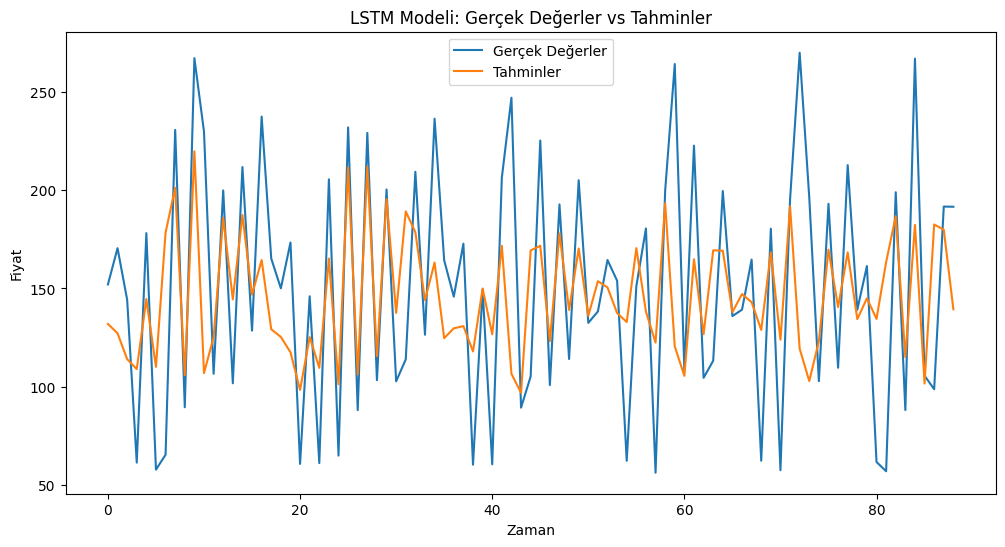

Evaluating BiLSTM model...
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0396
BiLSTM Test Loss: 0.04538115859031677
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 348ms/step


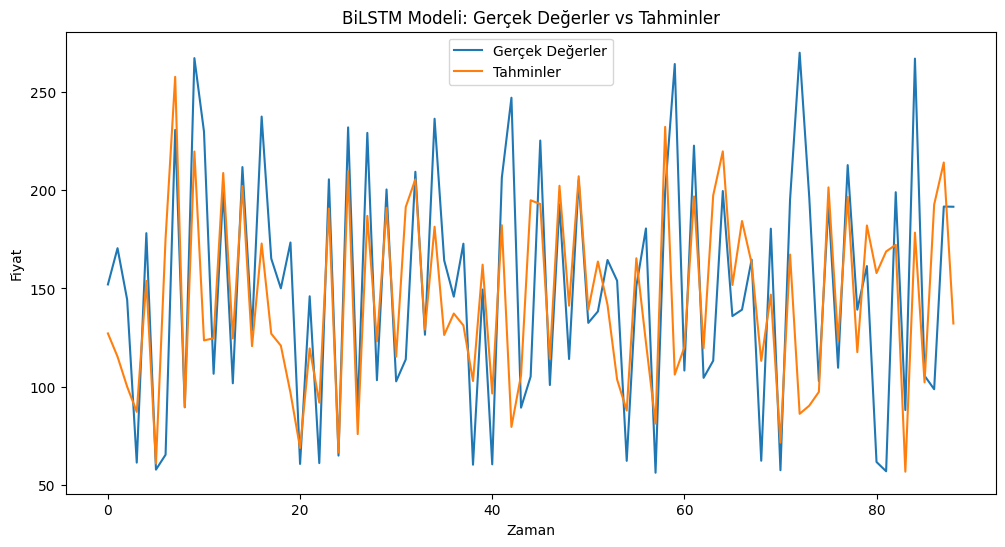

Evaluating CNN+LSTM model...
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0415
CNN+LSTM Test Loss: 0.0472215972840786
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step


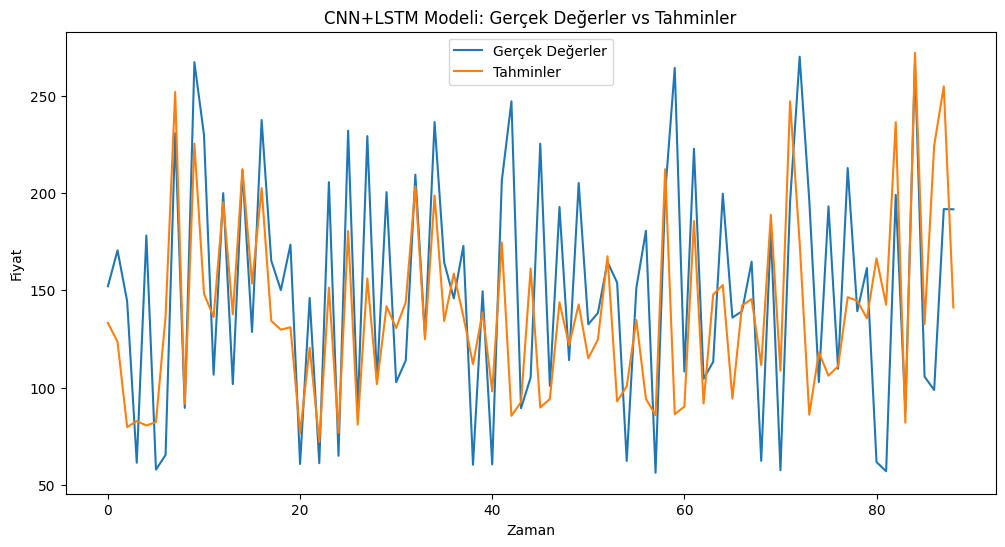

In [ ]:
# Model performansını değerlendirme
for name, model in models.items():
    print(f'Evaluating {name} model...')
    loss = model.evaluate(X_test, y_test)
    print(f'{name} Test Loss: {loss}')

    # Tahmin yapma
    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions)  # Tahminleri geri dönüştür

    # Gerçek değerleri geri dönüştür
    y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Grafikleri oluşturma
    plt.figure(figsize=(12, 6))
    plt.plot(y_test_rescaled, label='Gerçek Değerler')
    plt.plot(predictions, label='Tahminler')
    plt.title(f'{name} Modeli: Gerçek Değerler vs Tahminler')
    plt.xlabel('Zaman')
    plt.ylabel('Fiyat')
    plt.legend()
    plt.show()


In [ ]:
import pandas as pd

file_path = 'stock_data.csv'
df = pd.read_csv(file_path, thousands='.', decimal=',')

# Boş hücreleri kontrol et
print("Boş değer sayısı:")
print(df.isnull().sum())

# Hangi satırlarda boş değer var görelim
print("\nBoş değer içeren satırlar:")
print(df[df.isnull().any(axis=1)])


Boş değer sayısı:
Tarih     0
Şimdi     0
Açılış    0
Yüksek    0
Düşük     0
Hac.      0
Fark %    0
dtype: int64

Boş değer içeren satırlar:
Empty DataFrame
Columns: [Tarih, Şimdi, Açılış, Yüksek, Düşük, Hac., Fark %]
Index: []
